In [1]:
%cd ..

/home/work/AnacondaProjects/categorical_bpl


In [2]:
import argparse
import collections
import random
import pyro
import torch
import matplotlib.pyplot as plt
import numpy as np
import data_loader.data_loaders as module_data
import model.model as module_arch
from parse_config import ConfigParser
from trainer import Trainer

In [3]:
%matplotlib inline

In [4]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [5]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

In [6]:
Args = collections.namedtuple('Args', 'config resume device')
config = ConfigParser.from_args(Args(config='omniglot_config.json', resume=None, device=None))

In [7]:
logger = config.get_logger('train')

In [8]:
# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# build model architecture, then print to console
model = config.init_obj('arch', module_arch)

In [10]:
model.resume_from_checkpoint('saved/models/Omniglot_GlimpseCategory/0930_173926/checkpoint-epoch2000.pth')

In [11]:
validation_data = random.choice(list(valid_data_loader))[0]

In [12]:
path, prediction_data = model(observations=validation_data, train=False)

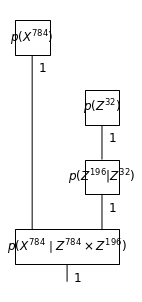

<AxesSubplot:>

In [13]:
path.draw()

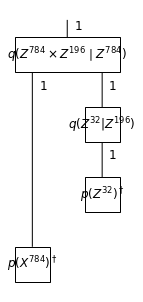

<AxesSubplot:>

In [14]:
path.dagger().draw()

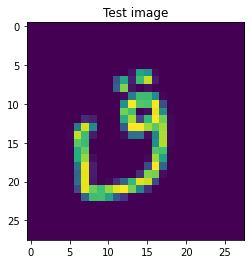

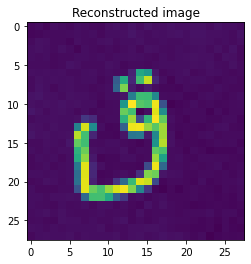

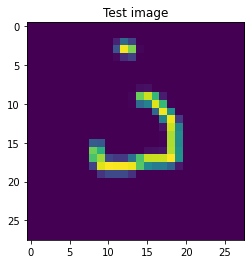

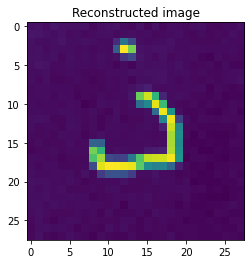

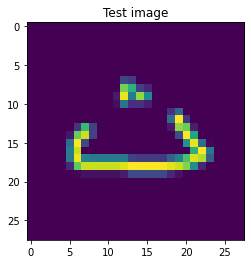

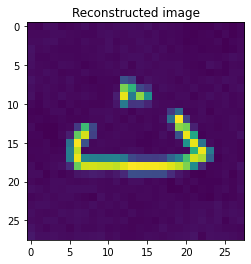

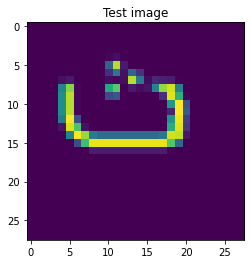

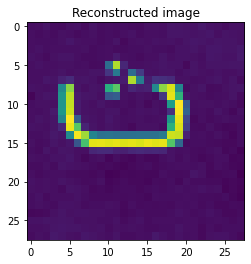

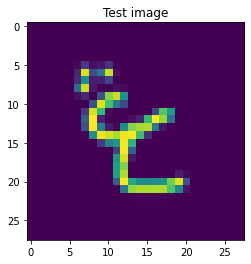

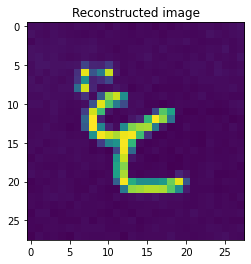

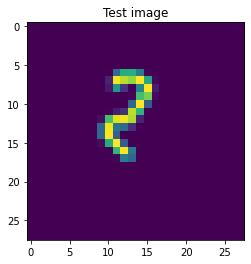

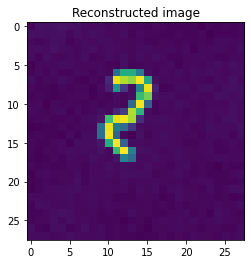

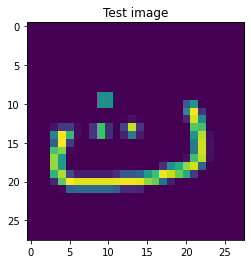

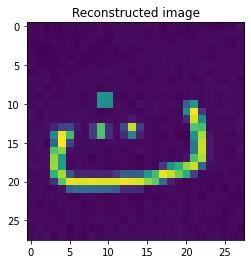

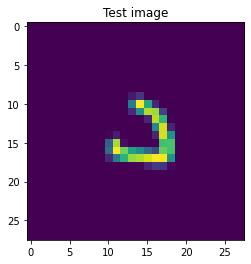

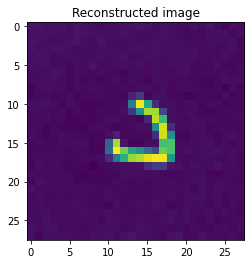

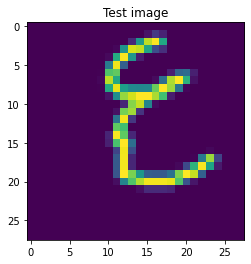

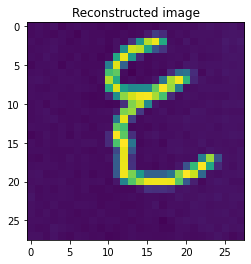

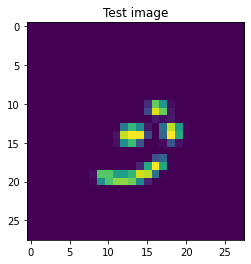

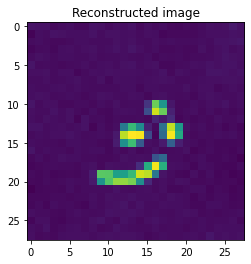

In [15]:
for k in np.random.randint(0, validation_data.shape[0], 10):
    image = validation_data[k].view(28, 28).detach().cpu().numpy()
    plt.title('Test image')
    plt.imshow(image)
    plt.show()

    prediction = prediction_data[k].view(28, 28).detach().cpu().numpy()
    plt.title('Reconstructed image')
    plt.imshow(prediction)
    plt.show()

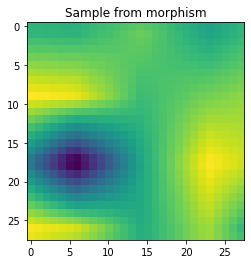

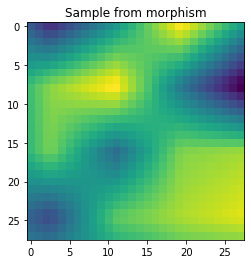

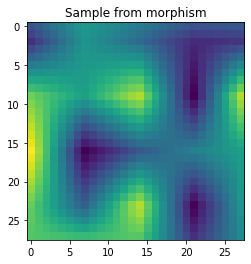

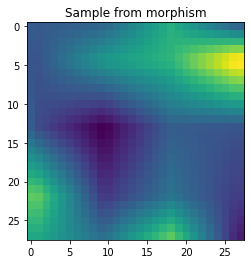

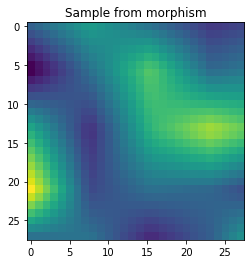

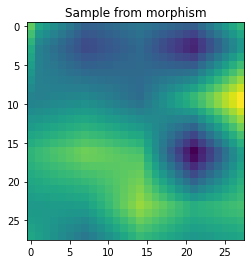

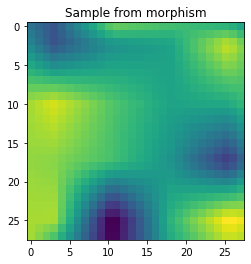

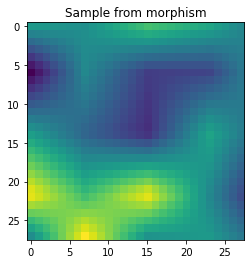

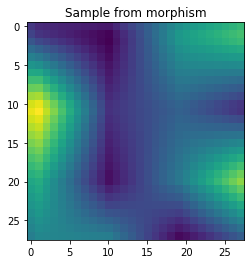

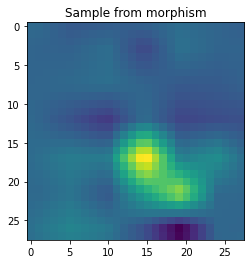

In [16]:
sample = path()
sample = sample.view(-1, 28, 28).detach().cpu().numpy()
    
for k in range(10):
    plt.title('Sample from morphism')
    plt.imshow(sample[k])
    plt.show()

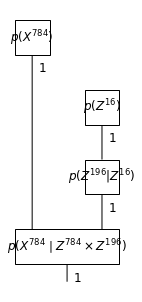

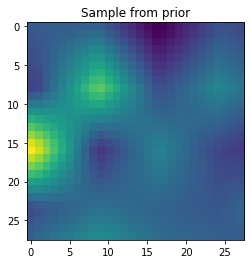

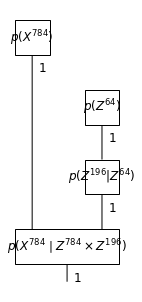

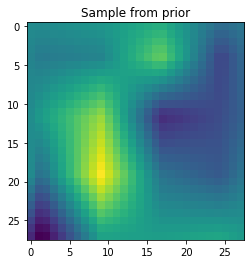

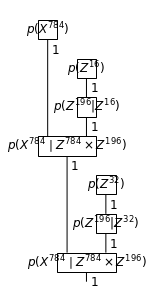

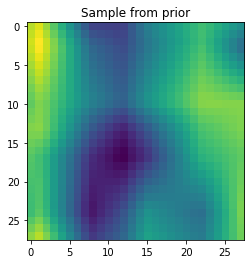

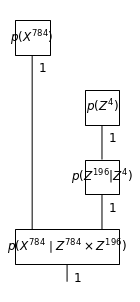

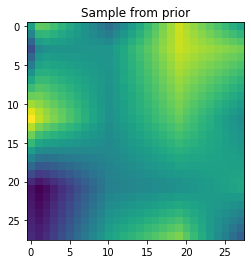

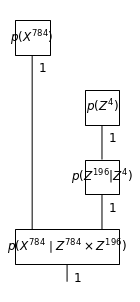

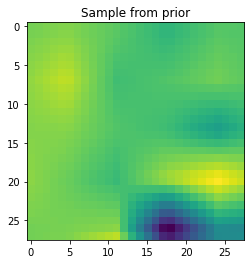

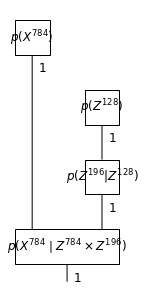

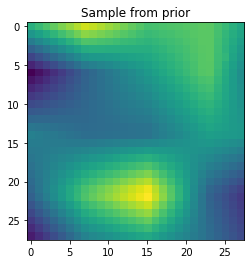

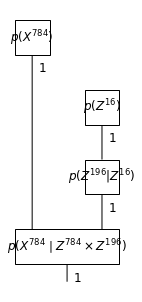

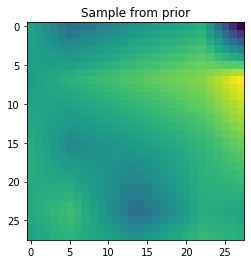

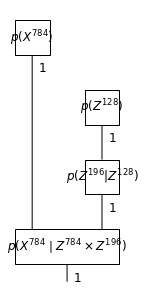

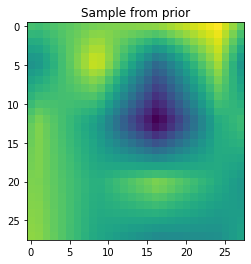

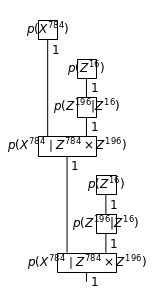

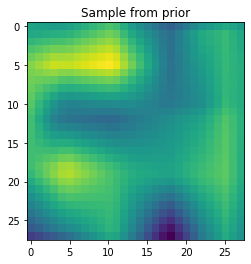

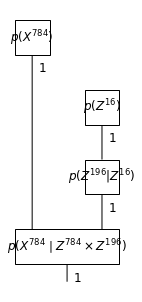

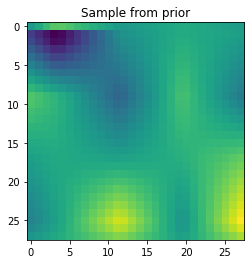

In [17]:
for k in range(10):
    path, sample = model(None)
    path.draw()
    sample = sample.view(28, 28).detach().cpu().numpy()
    plt.title('Sample from prior')
    plt.imshow(sample)
    plt.show()

Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral
Substituting symbol R from STIXGeneral


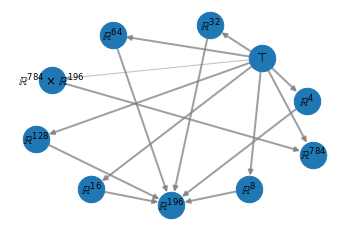

In [18]:
model._category.draw(filename='free_category.png')